In [1]:
card_name = 'q2only_test'

# Import

In [2]:
import sys, os
sys.path.append('../lib')

In [3]:
import numpy as np
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [4]:
file_loc = {
# 'data' : '../data/cmsRD/Run2018D/B02DstMu_190517_BPH*.root',
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
}

branches = ['q2', 'Est_mu', 'M2_miss',
            'mass_MuDst', 'cos_MuDst_vtxBest'
           ]

dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches, flag=k)
    print k, ':', dSet[k]['Est_mu'].shape[0], 'candidates'

mu : 15963 candidates
tau : 7222 candidates


In [5]:
analysis_selection = {
'mass_MuDst'      : ['<', 5.280],
'cos_MuDst_vtxBest' : ['>', 0.98]
}

binning = {
'q2'      : [10, -2, 10.7]
# 'q2'      : [4, -2, 10.7]
# 'M2_miss' : [40/2, -5, 10]
# 'Est_mu'  : [30/2, 0.10, 2.500]
}

In [6]:
histo= {}
for k in file_loc.keys():
#     histo[k] = rt.TH3F('h_'+k, k, 
#                      binning['q2'][0], binning['q2'][1], binning['q2'][2],
#                      binning['M2_miss'][0], binning['M2_miss'][1], binning['M2_miss'][2],      
#                      binning['Est_mu'][0], binning['Est_mu'][1], binning['Est_mu'][2]
#                     )
    histo[k] = rt.TH1F(k, k, 
                     binning['q2'][0], binning['q2'][1], binning['q2'][2]
                    )

    d = dSet[k]
    sel = createSel(d, analysis_selection)
#     rtnp.fill_hist(histo[k], np.column_stack((d['q2'][sel], d['M2_miss'][sel], d['Est_mu'][sel])))
    rtnp.fill_hist(histo[k], d['q2'][sel])
    
# Add overflow in the last visible bin

In [7]:
raw_yeld_inj = 0.2
N_tot = 1000

sel = createSel(dSet['mu'], analysis_selection)
n_mu = np.random.poisson(lam=N_tot*(1-raw_yeld_inj))
idx = np.random.randint(0, np.sum(sel), size=(n_mu, ))
d_mu = dSet['mu']['q2'][sel]
d_mu = d_mu[idx]

sel = createSel(dSet['tau'], analysis_selection)
n_tau = np.random.poisson(lam=N_tot*raw_yeld_inj)
idx = np.random.randint(0, np.sum(sel), size=(n_tau, ))
d_tau = dSet['tau']['q2'][sel]
d_tau = d_tau[idx]

histo['data'] = rt.TH1F('dataObs', 'data obs', 
                        binning['q2'][0], binning['q2'][1], binning['q2'][2]
                       )
rtnp.fill_hist(histo['data'], np.concatenate((d_mu, d_tau)))
print n_mu, n_tau

792 185


Scale according expectation and save file

In [8]:
#
histo['mu'].Scale(N_tot*(1-raw_yeld_inj)/histo['mu'].Integral())
histo['tau'].Scale(N_tot*raw_yeld_inj/histo['tau'].Integral())

In [9]:
histo_file_loc = '../data/_root/histos4combine_{}.root'.format(card_name)
tf = rt.TFile(histo_file_loc, 'recreate')
for k,v in histo.iteritems():
    v.Write()
tf.Close()

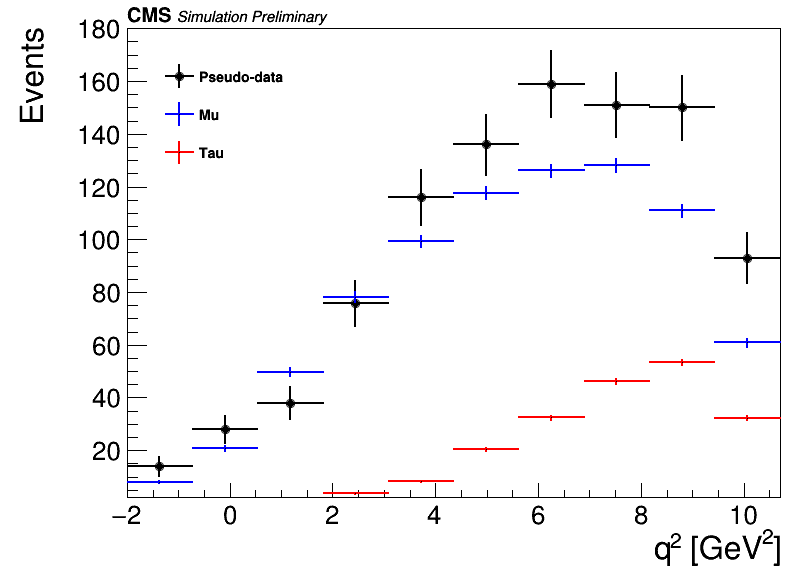

In [10]:
leg = rt.TLegend(0.2, 0.7, 0.4, 0.9)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

histo['data'].Sumw2()
histo['data'].SetMarkerColor(1)
histo['data'].SetMarkerStyle(20)
histo['data'].SetLineColor(1)
histo['data'].SetXTitle('q^{2} [GeV^{2}]')
histo['data'].SetYTitle('Events')
leg.AddEntry(histo['data'], 'Pseudo-data', 'lep')

histo['mu'].SetLineColor(4)
leg.AddEntry(histo['mu'], 'Mu', 'lep')

histo['tau'].SetLineColor(2)
leg.AddEntry(histo['tau'], 'Tau', 'lep')

CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [histo['data'], histo['mu'], histo['tau']], 'same')
leg.Draw()
c.Draw()

# Write the card

In [11]:
processes = ['mu', 'tau']

In [12]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [13]:
# number of different categories
card = 'imax 1\n'

# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)

# number of nuissance parameters
card += 'kmax *\n'
card += '---------------\n'

In [14]:
card += 'shapes * cat1 ' + histo_file_loc + ' $PROCESS $PROCESS__$SYSTEMATIC\n'
card += '---------------\n'

In [15]:
card += 'bin cat1\n'
card += 'observation {:.0f}\n'.format(histo['data'].Integral())
card += '---------------\n'

In [16]:
card += 'bin ' + ' '.join(['cat1']*2) + '\n'
card += 'process ' + ' '.join(processes) + '\n'

# Zero or negative for sig and positive for bkg
card += 'process ' + '0 1\n'

card += 'rate ' + ' {} {}\n'.format(N_tot*(1-raw_yeld_inj), N_tot*raw_yeld_inj)

In [17]:
print card

imax 1
jmax 1
kmax *
---------------
shapes * cat1 ../data/_root/histos4combine_q2only_test.root $PROCESS $PROCESS__$SYSTEMATIC
---------------
bin cat1
observation 961
---------------
bin cat1 cat1
process mu tau
process 0 1
rate  800.0 200.0



In [18]:
fc.write(card)
fc.close()

### Create output directory

In [19]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir)

0

# Run Combine

In [20]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' -d ' + card_location
cmd += ' --verbose 1'
cmd += ' -D ' + histo['data'].GetName()
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'

In [21]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv higgsCombineTest.FitDiagnostics.mH120.root ' + outdir + '/')

combine -M FitDiagnostics -d cards/q2only_test.txt --verbose 1 -D dataObs --out results/q2only_test --saveShapes --saveWithUncertainties --plots


0

 <<< Combine >>> 
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Parameters: 
  1) RooRealVar:: n_exp_bincat1_proc_tau = 200
  2) RooRealVar::                      r = 0
Obs: 
  1) RooRealVar::    CMS_th1x = 9.5
  2) RooCategory:: CMS_channel = cat1(idx = 0)

Running Minos for POI 
 PDF CHECKING 
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes:  [MAIN_MEASUREMENT,SnapShot_ExtRefClone,forceGenBinned] 
  Address: 0x7e21570
  Clients: 
    (0x7ff72c0,V-) RooSimultaneousOpt::model_s "model_s"
  Servers: 
    (0x5f1b160,V-) FastVerticalInterpHistPdf2::shapeSig_mu_cat1_rebinPdf ""
    (0x7ebfe30,V-) FastVerticalInterpHistPdf2::shapeBkg_tau_cat1_rebinPdf ""
    (0x7fe50b0,V-) ProcessNormalization::n_exp_bincat1_proc_mu ""
    (0x7eb26f0,V-) RooRealVar::n_exp_bincat1_proc_tau "n_exp_bincat1_proc_tau"
  Proxies: 
    !refCoefNorm -> 
    !refCoefNorm -> 
    !pdfs -> 
      1)   shapeSig_mu_cat1_rebinPdf
      2)  shapeBkg_tau_cat1_rebinPdf

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-5LBBF3.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
PDF didn't factorize!
Error in <TList::Clear>: A list is accessing an object (0x801d874) already deleted (list name = TList)
Info in <TCanvas::Print>: png file results/q2only_test/cat1_CMS_th1x_fit_s.png has been created
Info in <TCanvas::Print>: png file results/q2only_test/covariance_fit_s.png has been created
